# Word vector and PCA analysis of tokens

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('pymodules')
# Gensim
from gensim.models import Word2Vec
# making the plot look good ...
from adjustText import adjust_text
from sklearn.decomposition import PCA
# this class read the raw input and tokenizes comprehensively for use with modeling
import pymodules.read_and_tokenize as contacts_utils


/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Read file and preprocess to generate tokens

In [2]:
filename = "data/Master-data_Q42021.xlsx"
prep_comments, df = contacts_utils.read_file(filename)

Read sheet 'Scrubbed_data' ...
Columns:Index(['TITLE', 'COMMENTS', 'OVERALL_RATING', 'COMFORT_RATING',
       'VISION_RATING', 'VALUE_FOR_MONEY', 'AUTHOR', 'PROS', 'CONS',
       'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'FINAL_PRODUCT_NAME',
       'PRODUCT_LINK', 'WEBSITE', 'RATING', 'PRODUCT', 'BRAND'],
      dtype='object')
Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index

### Add bigrams to the word tokens so that sentiments are expressed better by word tokens and word-pairs

In [3]:
require_bigrams = True
if require_bigrams:
    for i in range(len(prep_comments.tokens)):
        prep_comments.tokens[i] = prep_comments.tokens[i] + prep_comments.bigrams[i]

test_index = 0
print(f"Comments at index[{test_index}] after addition of bigrams:\n {prep_comments.tokens[test_index]}")
print(f"Comments at index[{-1}] after addition of bigrams:\n {prep_comments.tokens[-1]}")

Comments at index[0] after addition of bigrams:
 ['used', 'for', 'long', 'time', 'and', 'say', 'service', 'from', 'com', 'great', 'and', 'work', 'great', 'for', 'needs', 'highly', 'recommend', 'used-for', 'for-long', 'long-time', 'time-and', 'and-say', 'say-service', 'service-from', 'from-com', 'com-great', 'great-and', 'and-work', 'work-great', 'great-for', 'for-needs', 'needs-highly', 'highly-recommend']
Comments at index[-1] after addition of bigrams:
 ['buy', 'again', 'order', 'came', 'fast', 'without', 'any', 'issues', 'and', 'candy', 'nice', 'touch', 'buy-again', 'again-order', 'order-came', 'came-fast', 'fast-without', 'without-any', 'any-issues', 'issues-and', 'and-candy', 'candy-nice', 'nice-touch']


In [4]:
df['TOKENS'] = prep_comments.tokens

### Train gensim model to generate word embeddings
* Word embeddings vector is of size 100
* It is based on universal dictionary
* Each word/token now is expressed as a vector of 100 arbitrary, deterministic features. i.e. a word is embedded in a $R^{100}$ basis space

In [5]:
# train Gensim's Word2Vec model
gensim_model = Word2Vec(sentences=prep_comments.tokens,      # corpus
                        vector_size=100,            # embedding dimension
                        window=4,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=5,                 # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=10,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=4,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                        )

### Do gensim validation to ensure that word embeddings have been generated

In [6]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors.vectors.shape  # vocab_size x embeddings dimension

(33417, 100)

In [7]:
word_vectors_weights = gensim_model.wv.vectors
vocab_size, embedding_size = word_vectors_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 33417 - Embedding Dim: 100


In [8]:
# Some validation on the quality of the Word2Vec model
print(gensim_model.wv.most_similar('product', topn=3))
print(gensim_model.wv.most_similar('price', topn=3))
print(gensim_model.wv.most_similar('service', topn=3))
print(gensim_model.wv.most_similar('quality', topn=3))
print(gensim_model.wv.most_similar(positive=['comfort', 'fit'], negative=['dry'], topn=3))

def word2token(word):
    try:
        return gensim_model.wv.key_to_index[word]
    except KeyError:
        return 0

def token2word(token):
    return gensim_model.wv.index_to_key[token]

[('usual', 0.8692267537117004), ('complaints', 0.8607142567634583), ('consistent', 0.858058512210846)]
[('reasonable', 0.8734105825424194), ('all-around', 0.8631464838981628), ('value', 0.8619769215583801)]
[('prompt', 0.9207313656806946), ('support', 0.9169158339500427), ('customer', 0.9140909910202026)]
[('inexpensive', 0.9041377305984497), ('high', 0.8839538097381592), ('value', 0.8782742619514465)]
[('comfort-and', 0.7850692272186279), ('comfort-fit', 0.773332417011261), ('and-comfort', 0.7716785073280334)]


### Encode word embeddings
* Test key to index for word vectors, so we can go back and forth between word and its embedding

In [9]:
word_vectors[word_vectors.key_to_index['dry']]

array([-8.3539772e-01,  6.5436226e-01, -2.1894004e-02,  1.1947187e+00,
       -6.9086331e-01,  2.6098144e-01, -3.7536281e-01,  6.9518578e-01,
        4.9636222e-04,  4.3642938e-02,  8.3860856e-01,  4.1755453e-01,
        1.6696442e-02, -3.8540351e-01, -4.2207226e-01, -4.9301967e-01,
       -2.9740989e-01, -3.0036032e-01,  5.0448585e-01, -9.2318034e-01,
        9.7717583e-01, -9.9019013e-02, -1.4640312e-01,  3.7586644e-01,
       -1.7172245e-02, -9.9121928e-02,  1.5083405e-01,  9.0033403e-03,
        2.0798822e-01,  3.3619836e-01,  4.7168216e-01,  6.7387164e-01,
       -7.2860706e-01,  3.0616587e-01,  5.9688663e-01,  5.7600760e-01,
        7.2356910e-01,  1.0903382e-01,  7.1026313e-01, -5.8182293e-01,
        4.4770944e-01, -2.4453159e-02, -5.8070427e-01,  2.1313286e-01,
       -2.1608460e-01,  7.7280092e-01,  2.0759165e-01,  2.2935568e-01,
       -2.1042161e-01,  2.4307901e-02,  9.9588329e-01,  1.1766075e-01,
        6.7111969e-02, -1.2479809e-01, -6.0505843e-01, -3.5367650e-01,
      

### Plot the scatter matrix of word embeddings to see relative distance of words

In [17]:
# use a PCA decomposition to visualize the embeddings in 2D
def pca_scatterplot(model, words):
    pca = PCA(n_components=2, random_state=92)
    word_vectors = np.array([model[w] for w in words])
    low_dim_emb = pca.fit_transform(word_vectors)
    plt.figure(figsize=(21,10))
    plt.scatter(low_dim_emb[:,0], low_dim_emb[:,1], edgecolors='blue', c='blue')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # get the text of the plotted words
    texts = []
    for word, (x,y) in zip(words, low_dim_emb):
        texts.append(plt.text(x+0.01, y+0.01, word, rotation=0))

    # adjust the position of the labels so that they dont overlap
    adjust_text(texts)
    # show plot
    plt.show()
    return low_dim_emb

### Show the PCA plot

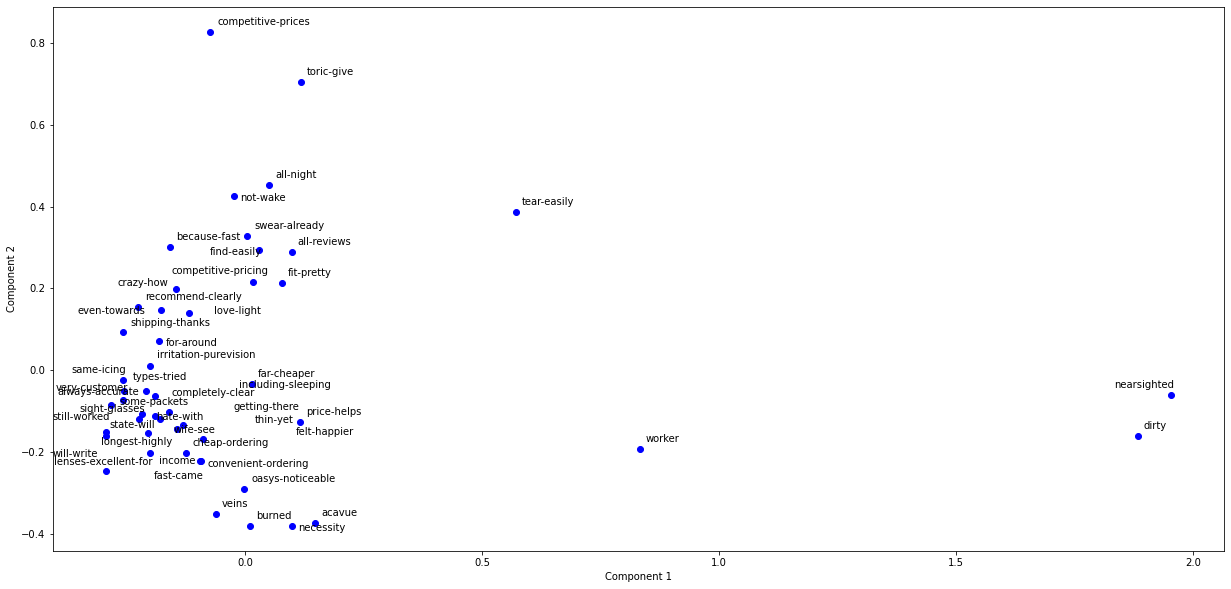

In [18]:
# plot these tokens from word vector ...
all_tokens = prep_comments.tokens
import itertools
flat_list_tokens = list(itertools.chain(*all_tokens))
token_set = list(set(flat_list_tokens))

#plot
pca_components = pca_scatterplot(word_vectors, token_set[:50])

### Interactive plot with Zoom

In [28]:
import plotly.express as px
from sklearn.decomposition import PCA

# plot first 50 tokens ...
tks = token_set[:50]
fig = px.scatter(pca_components, x=0, y=1, text=tks)
fig.update_traces(textposition='top center')
fig.update_traces(textfont=dict(size=[8]*len(tks)))
fig.show()